# Preprocessing


=== MULAI SMART SCANNING (OUTPUT MAXIMIZED) ===
[INFO] Deteksi Sudut Gagal. Beralih ke Adaptive Bounding Box.
[ANALISIS ORIENTASI] Horizontal Votes: 0 | Vertical Votes: 0


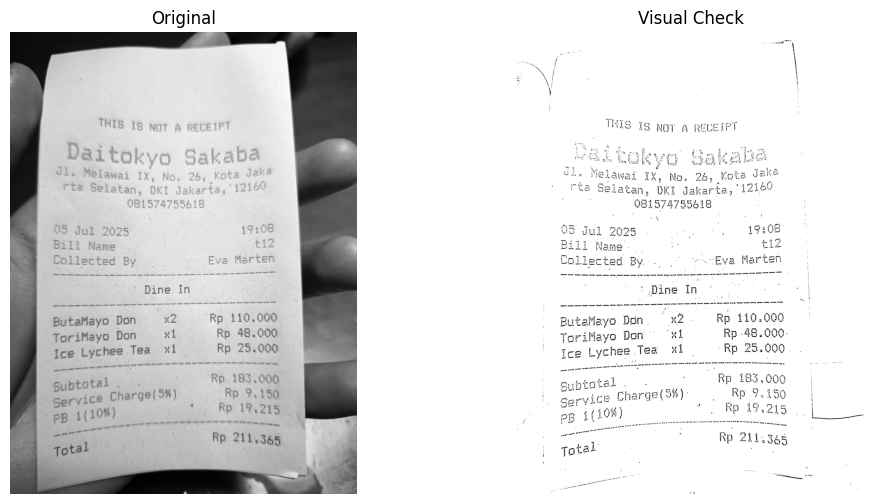

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.



=== HASIL BACAAN OCR ===
image path: ../../dataset/ekstra/test6.jpg

       OUTPUT STRUK DIGITAL
THiS 1s NOT A RECEIPT
Daitokyo Sakaba
Jl . Melawai IX , No . 26 , Kota Jaka
rta Selatan, DKI Jakarta, 12160
081574755618
05 Jul 2025 19,08
Bill Nane t1z
Collected By Eva Marter
Dine In
ButaMayo Don *2 RP 110.Q00
ToriMayo Don X1 RP 48.QQ0
Tea X1 Rp 25_ 0 000
PRICE L Lychee
Rp 185.000
SUBTOTAL
CHARGE 5%) RP 9,1 50
SERVICE
RP 19.215
PB 1(10%)
RP 211.J65
TOTAL


In [39]:
import cv2
import numpy as np
import easyocr
from matplotlib import pyplot as plt
import os
import difflib
import re
import math

# Magic command agar plot muncul di notebook
%matplotlib inline

# ==========================================
# BAGIAN 1: PREPROCESSING (TIDAK DIUBAH)
# ==========================================

def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
    return warped

def safe_crop_with_padding(image, x, y, w, h, padding_pct=0.1):
    h_img, w_img = image.shape[:2]
    pad_w = int(w * padding_pct)
    pad_h = int(h * padding_pct)
    x1 = max(0, x - pad_w)
    y1 = max(0, y - pad_h)
    x2 = min(w_img, x + w + pad_w)
    y2 = min(h_img, y + h + pad_h)
    return image[y1:y2, x1:x2]

def auto_scan_document(image):
    orig = image.copy()
    ratio = image.shape[0] / 500.0
    h = 500
    w = int(image.shape[1] / ratio)
    small_img = cv2.resize(image, (w, h))
    total_area = h * w
    gray = cv2.cvtColor(small_img, cv2.COLOR_BGR2GRAY) if len(small_img.shape) == 3 else small_img
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
    screenCnt = None
    strategy_used = ""
    largest_contour = None
    max_area = 0
    for c in contours:
        area = cv2.contourArea(c)
        if area > max_area:
            max_area = area
            largest_contour = c
        if area < (total_area * 0.05): continue
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            screenCnt = approx
            strategy_used = "Perfect 4-Point"
            break
    if screenCnt is not None:
        print(f"[INFO] Deteksi Berhasil: {strategy_used}")
        pts = screenCnt.reshape(4, 2) * ratio
        warped = four_point_transform(orig, pts)
        return warped, True
    elif largest_contour is not None and max_area > (total_area * 0.1):
        print("[INFO] Deteksi Sudut Gagal. Beralih ke Adaptive Bounding Box.")
        x, y, w_box, h_box = cv2.boundingRect(largest_contour)
        x = int(x * ratio); y = int(y * ratio); w_box = int(w_box * ratio); h_box = int(h_box * ratio)
        cropped = safe_crop_with_padding(orig, x, y, w_box, h_box, padding_pct=0.1)
        return cropped, False
    else:
        print("[INFO] Objek tidak jelas. Melakukan Safe Center Zoom.")
        h_orig, w_orig = orig.shape[:2]
        center_h, center_w = h_orig // 2, w_orig // 2
        crop_h = int(h_orig * 0.7); crop_w = int(w_orig * 0.7)
        y1 = max(0, center_h - crop_h // 2); y2 = min(h_orig, center_h + crop_h // 2)
        x1 = max(0, center_w - crop_w // 2); x2 = min(w_orig, center_w + crop_w // 2)
        cropped = orig[y1:y2, x1:x2]
        return cropped, False

def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0]); sin = np.abs(M[0, 1])
    nW = int((h * sin) + (w * cos)); nH = int((h * cos) + (w * sin))
    M[0, 2] += (nW / 2) - cX; M[1, 2] += (nH / 2) - cY
    return cv2.warpAffine(image, M, (nW, nH), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

def remove_borders(image):
    img_padded = cv2.copyMakeBorder(image, 20, 20, 20, 20, cv2.BORDER_CONSTANT, value=(255, 255, 255))
    return img_padded

def detect_orientation_and_deskew(image):
    clean_image = remove_borders(image)
    gray = cv2.cvtColor(clean_image, cv2.COLOR_BGR2GRAY) if len(clean_image.shape) == 3 else clean_image
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 25, 15)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 3))
    dilated = cv2.dilate(thresh, kernel, iterations=1)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    horizontal_votes = 0; vertical_votes = 0; angles = []
    for c in contours:
        area = cv2.contourArea(c)
        if area < 100 or area > (image.shape[0] * image.shape[1] * 0.5): continue
        rect = cv2.minAreaRect(c)
        (center, (w, h), angle) = rect
        if w < h: w, h = h, w; angle += 90
        aspect_ratio = w / float(h) if h > 0 else 0
        if aspect_ratio > 2.0:
            horizontal_votes += 1
            if angle > 45: angle -= 90
            elif angle < -45: angle += 90
            angles.append(angle)
        elif aspect_ratio < 0.5: vertical_votes += 1
    print(f"[ANALISIS ORIENTASI] Horizontal Votes: {horizontal_votes} | Vertical Votes: {vertical_votes}")
    if vertical_votes > horizontal_votes * 1.5:
        print("[KEPUTUSAN] Terdeteksi Teks Vertikal Dominan. Rotasi 90 Derajat.")
        return cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    else:
        if len(angles) > 5: 
            median_angle = np.median(angles)
            print(f"[KEPUTUSAN] Deskew halus: {median_angle:.2f} derajat.")
            if abs(median_angle) > 20: return image
            elif abs(median_angle) < 0.5: return image
            else: return rotate_image(image, median_angle)
        else: return image

def tuning_lab(image, blur_kernel=21, denoise_h=10, upscale=False):
    if image is None: return None
    processed_img, success = auto_scan_document(image)
    processed_img = detect_orientation_and_deskew(processed_img)
    if upscale:
        processed_img = cv2.resize(processed_img, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_CUBIC)
    
    # Visual check binary (hanya untuk plot, tidak dipakai OCR)
    visual_binary = cv2.adaptiveThreshold(
        processed_img, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 15, 10
    )
    
    # Image cleaning untuk OCR
    ocr_ready_img = cv2.fastNlMeansDenoising(processed_img, None, h=denoise_h, templateWindowSize=7, searchWindowSize=21)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1); plt.imshow(image, cmap='gray'); plt.title("Original"); plt.axis('off')
    plt.subplot(1, 2, 2); plt.imshow(visual_binary, cmap='gray'); plt.title("Visual Check"); plt.axis('off')
    plt.show()
    
    return ocr_ready_img

# ==========================================
# BAGIAN 2: POST-PROCESSING (DIMAKSIMALKAN)
# ==========================================

def smart_number_correction(text):
    '''
    Fungsi Baru: Khusus memperbaiki angka yang salah baca.
    Contoh: '1O.OOO' -> '10.000', 'l500' -> '1500'
    '''
    # Cek apakah kata mengandung kombinasi angka dan huruf O/l/I
    if any(c.isdigit() for c in text):
        # Ganti O/o dengan 0
        text = re.sub(r'[Oo]', '0', text)
        # Ganti l/I dengan 1 (hati-hati, hanya jika konteksnya angka)
        text = re.sub(r'[lI]', '1', text)
    return text

def apply_spell_correction(text_line):
    '''Dimodifikasi untuk memanggil smart_number_correction'''
    RECEIPT_KEYWORDS = [
        "TOTAL", "SUBTOTAL", "CASH", "CHANGE", "PAYMENT", "DEBIT", "CREDIT",
        "TAX", "PAJAK", "PPN", "HARGA", "PRICE", "ITEM", "QTY", "AMOUNT",
        "RECEIPT", "STRUK", "KEMBALI", "TUNAI", "DISKON", "DISCOUNT", "OFFER",
        "SERVICE", "CHARGE", "GRAND"
    ]
    
    words = text_line.split()
    corrected_words = []
    
    for word in words:
        clean_word = ''.join(e for e in word if e.isalnum())
        
        # 1. Cek Koreksi Angka (Prioritas)
        word = smart_number_correction(word)
        
        # 2. Cek Koreksi Keyword
        if len(clean_word) < 3:
            corrected_words.append(word)
            continue
            
        matches = difflib.get_close_matches(clean_word.upper(), RECEIPT_KEYWORDS, n=1, cutoff=0.75)
        if matches:
            corrected_words.append(matches[0])
        else:
            corrected_words.append(word)
            
    return " ".join(corrected_words)

def cleanup_text_spacing(text):
    '''Membersihkan spasi pada angka dan mata uang'''
    # 10 . 000 -> 10.000
    text = re.sub(r'(\d)\s*([.,])\s*(\d)', r'\1\2\3', text) 
    # Rp 10 -> Rp 10
    text = re.sub(r'(Rp|IDR)\s*(\d)', r'\1 \2', text, flags=re.IGNORECASE)
    # Hapus spasi ganda
    text = re.sub(r'\s{2,}', ' ', text)
    return text

def group_ocr_results(results, y_threshold=15):
    '''
    DIMAKSIMALKAN: 
    Sekarang mendeteksi jarak antar kata. Jika jaraknya jauh (misal Nama Barang ..... Harga),
    akan ditambahkan Tab (\t) agar layout struk tetap rapi kiri-kanan.
    '''
    # 1. Urutkan berdasarkan Y (Atas ke Bawah)
    sorted_results = sorted(results, key=lambda x: sum([p[1] for p in x[0]]) / 4)
    lines = []
    current_line = []
    
    for i, (bbox, text, conf) in enumerate(sorted_results):
        current_y = sum([p[1] for p in bbox]) / 4
        if not current_line:
            current_line.append((bbox, text))
            continue
        
        last_y = sum([p[1] for p in current_line[-1][0]]) / 4
        
        # Jika beda tinggi kecil, berarti satu baris
        if abs(current_y - last_y) < y_threshold:
            current_line.append((bbox, text))
        else:
            lines.append(current_line)
            current_line = [(bbox, text)]
            
    if current_line: lines.append(current_line)
        
    final_text_lines = []
    for line in lines:
        # 2. Urutkan berdasarkan X (Kiri ke Kanan)
        line.sort(key=lambda x: x[0][0][0]) 
        
        formatted_line_text = ""
        last_x_end = 0
        
        for i, (bbox, text) in enumerate(line):
            x_start = bbox[0][0] # Koordinat X kiri kata saat ini
            
            # Deteksi Jarak: Jika bukan kata pertama, dan jaraknya > 50 pixel, kasih Tab
            if i > 0:
                gap = x_start - last_x_end
                if gap > 50: # Angka 50 pixel adalah toleransi jarak untuk dianggap "kolom terpisah"
                    formatted_line_text += "\t\t" # Tambah tabulasi
                else:
                    formatted_line_text += " " # Spasi biasa
            
            formatted_line_text += text
            last_x_end = bbox[1][0] # Update koordinat X kanan kata saat ini
        
        # 3. Apply Correction & Cleanup
        corrected_text = apply_spell_correction(formatted_line_text)
        final_clean_text = cleanup_text_spacing(corrected_text)
        final_text_lines.append(final_clean_text)
        
    return "\n".join(final_text_lines)

# ==========================================
# EKSEKUSI
# ==========================================

img_path = "../../dataset/ekstra/test6.jpg" 

if os.path.exists(img_path):
    original_img = cv2.imread(img_path)
    gray_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    
    print("\n=== MULAI SMART SCANNING (OUTPUT MAXIMIZED) ===")
    result_image = tuning_lab(gray_img, blur_kernel=21, denoise_h=10, upscale=True)

    if result_image is not None:
        print("\n=== HASIL BACAAN OCR ===")
        # GPU diset True jika tersedia untuk performa lebih baik, tapi tidak wajib
        reader = easyocr.Reader(['en', 'id'], gpu=True) 
        
        # Detail=1 penting untuk mendapatkan koordinat box
        raw_results = reader.readtext(result_image, detail=1) 
        
        final_clean_text = group_ocr_results(raw_results, y_threshold=20)
        
        print(f"image path: {img_path}")
        print("\n" + "="*40)
        print("       OUTPUT STRUK DIGITAL")
        print("="*40)
        print(final_clean_text) 
        print("="*40)
else:
    print(f"❌ Gambar tidak ditemukan di path: {img_path}")